# **0. Note**
This is a fork of [TechopenCADD repo](https://github.com/volkamerlab/teachopencadd), I adapted it for internal training only. 

In [ ]:
!pip install rdkit-pypi tdqm

In [ ]:
import os
!git clone https://github.com/TieuLongPhan/Database.git
os.chdir("/content/Database/Training_cheminformatics")

Mounted at /content/drive


Number of molecules in dataset: 4635


,molecule_chembl_id,smiles,pIC50,Molecule
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,

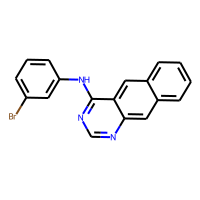
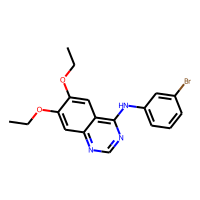
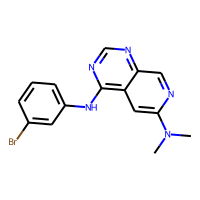
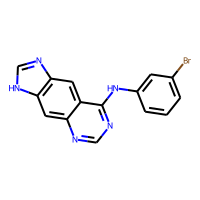
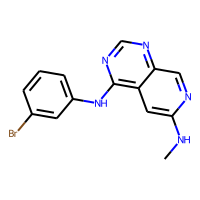

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from rdkit.Chem import PandasTools
import IPython
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools, AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.Draw import IPythonConsole #RDKit drawing => visualize
tqdm.pandas()
df = pd.read_csv("EGFR_compounds_lipinski.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(f"Number of molecules in dataset: {len(df)}")
PandasTools.AddMoleculeColumnToFrame(df,'smiles','Molecule',includeFingerprints=False)
df.head(5)

# **1. Molecular similarity**
Once the descriptors/fingerprints are calculated, they can be compared to assess the similarity between two molecules. Molecular similarity can be quantified with a number of different similarity coefficients, two common similarity measures are the Tanimoto and Dice index ([<i>J. Med. Chem.</i> (2014), <b>57</b>, 3186-3204](http://pubs.acs.org/doi/abs/10.1021/jm401411z)).

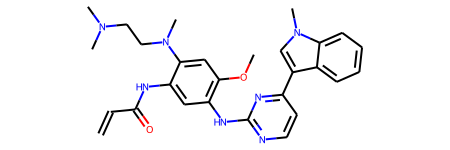

In [ ]:
import seaborn as sns
base = "CN1C=C(C2=CC=CC=C21)C3=NC(=NC=C3)NC4=C(C=C(C(=C4)NC(=O)C=C)N(C)CCN(C)C)OC" # query 

query = Chem.MolFromSmiles(base)
query.SetProp('_Name',"Osimertinib")
query

In [ ]:
circular_fp_query = AllChem.GetMorganFingerprintAsBitVect(query, 2, nBits=1024)
circular_fp_query

In [ ]:
from rdkit import Chem, DataStructs
PandasTools.AddMoleculeColumnToFrame(df, smilesCol = 'smiles')
def mol2fp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) 
    return fp
df["ecfp4"] = df.ROMol.progress_apply(mol2fp)
circular_fp_list = df["ecfp4"].tolist()

  0%|          | 0/4635 [00:00<?, ?it/s]

## 1.1. Tanimoto coefficient

$$T _{c}(A,B) = \frac{c}{a+b-c}$$

- a: number of features present in molecule A 
- b: number of features present in molecule B 
- c: number of features shared by molecules A and B

,molecule_chembl_id,smiles,pIC50,Molecule,ROMol,ecfp4,tanimoto_ecfp
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.139785
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.156250
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,,,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.156250

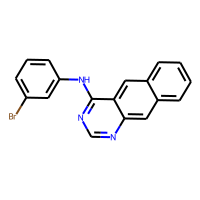
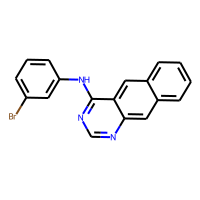
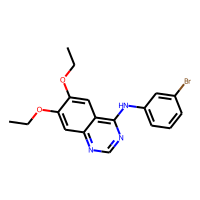
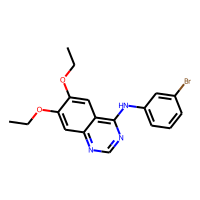
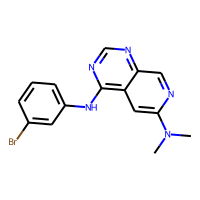
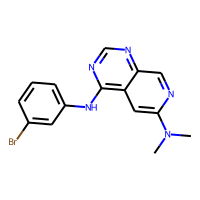

In [ ]:
df["tanimoto_ecfp"] = DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)
df.head(3)

## 1.2. Dice coefficient

$$D_{c}(A,B) = \frac{c}{\frac{1}{2}(a+b)}$$

- a: number of features present in molecule A
- b: number of features present in molecule B 
- c: number of features shared by molecules A and B

The similarity measures usually consider the number of positive bits (1's) present in either fingerprint and the number of positive bits that both have in common. 
Dice similarity usually returns higher values than Tanimoto similarity because of their denominators:

$$\frac{c}{a+b-c} \leq \frac{c}{\frac{1}{2}(a+b)}$$

,molecule_chembl_id,smiles,pIC50,Molecule,ROMol,ecfp4,tanimoto_ecfp,dice_ecfp
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.139785,0.245283
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.156250,0.270270
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,,,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.156250,0.270270

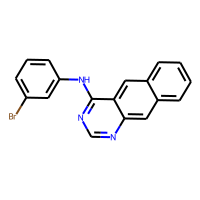
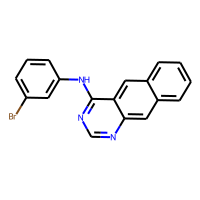
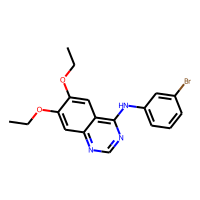
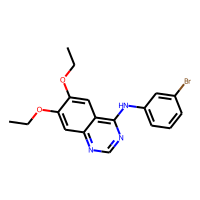
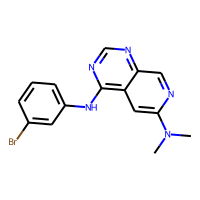
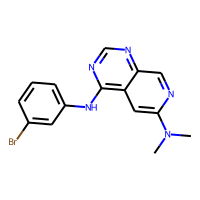

In [ ]:
df["dice_ecfp"] = DataStructs.BulkDiceSimilarity(circular_fp_query, circular_fp_list)
df.head(3)

## 1.3. Tversky coefficient

$$T _{c}(A,B) = \frac{c}{\alpha(a-c) + \beta(b-c) + c}$$

- a: number of features present in molecule A 
- b: number of features present in molecule B 
- c: number of features shared by molecules A and B

,molecule_chembl_id,smiles,pIC50,Molecule,ROMol,ecfp4,tanimoto_ecfp,dice_ecfp,Tversky_ecfp
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.139785,0.245283,0.245283
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.156250,0.270270,0.270270
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,,,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.156250,0.270270,0.270270

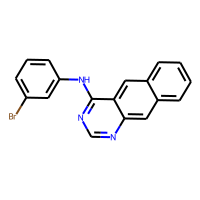
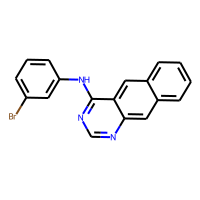
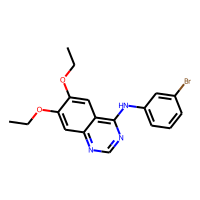
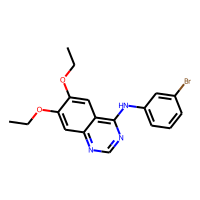
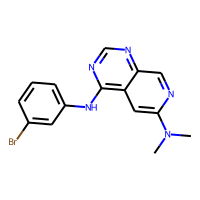
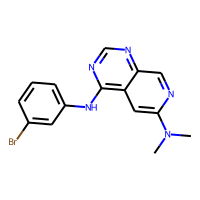

In [ ]:
df["Tversky_ecfp"] = DataStructs.BulkTverskySimilarity(circular_fp_query, circular_fp_list, 0.5, 0.5)
df.head(3)

# **2. Visualize**

(array([   5.,   53.,  271.,  912., 1037., 1036.,  927.,  348.,   38.,
           8.]),
 array([ 1.60205999,  2.59414187,  3.58622374,  4.57830562,  5.57038749,
         6.56246937,  7.55455124,  8.54663312,  9.53871499, 10.53079687,
        11.52287875]),
 <a list of 10 Patch objects>)

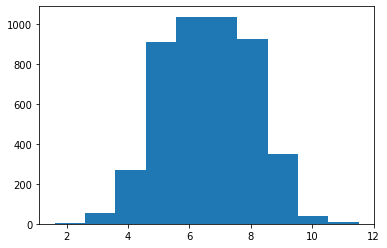

In [ ]:
plt.hist(df.pIC50)

,molecule_chembl_id,smiles,pIC50,Molecule,ROMol,ecfp4,tanimoto_ecfp,dice_ecfp,Tversky_ecfp
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.139785,0.245283,0.245283
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.156250,0.270270,0.270270

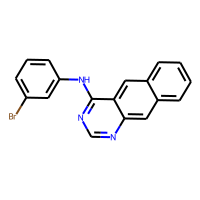
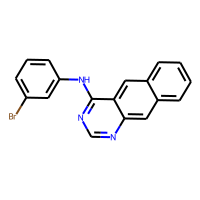
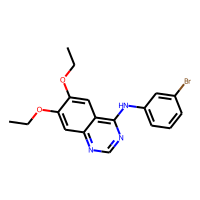
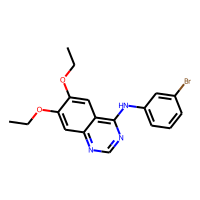

In [ ]:
df.head(2)

In [ ]:
df = df[['pIC50', "tanimoto_ecfp", "dice_ecfp", "Tversky_ecfp",]]

In [ ]:
# Add column for activity
df["active"] = np.zeros(len(df))

# Mark every molecule as active with an pIC50 of >= 8, 0 otherwise
df.loc[df[df.pIC50 >= 8].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(df.active.sum()))
print("Number of inactive compounds:", len(df) - int(df.active.sum()))

Number of active compounds: 906
Number of inactive compounds: 3729


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [ ]:
df.head(2)

,pIC50,tanimoto_ecfp,dice_ecfp,Tversky_ecfp,active
0,11.522879,0.139785,0.245283,0.245283,1.0
1,11.221849,0.156250,0.270270,0.270270,1.0


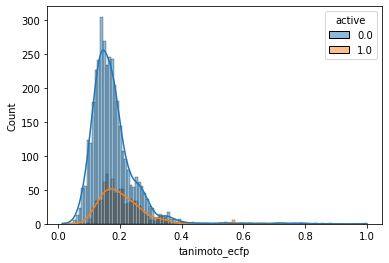

In [ ]:
sns.histplot(data = df, x=df["tanimoto_ecfp"], kde = True, hue=df["active"])

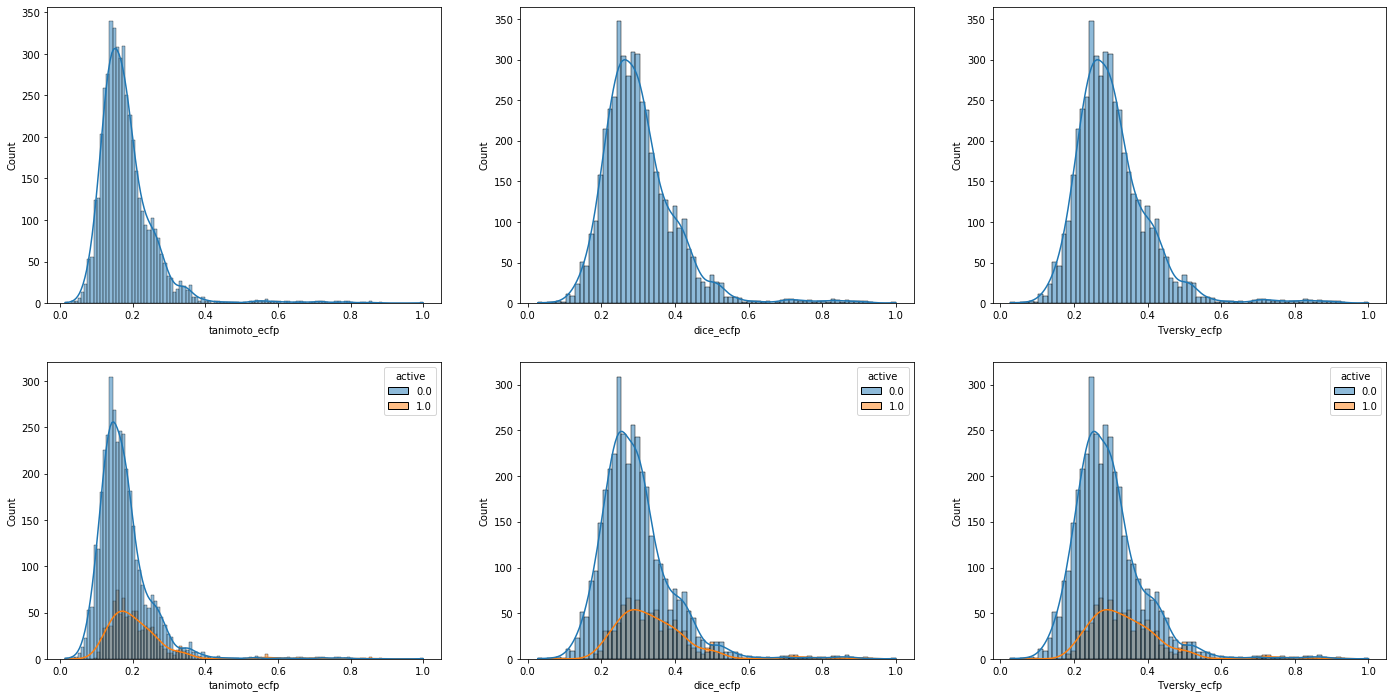

In [ ]:
fig, axes = plt.subplots(figsize=(24, 12), nrows=2, ncols=3)

sns.histplot(data = df, x=df["tanimoto_ecfp"], ax=axes[0, 0], kde = True, )
sns.histplot(data = df, x=df["dice_ecfp"], ax=axes[0, 1],kde = True, )
sns.histplot(data = df, x=df["Tversky_ecfp"],ax=axes[0, 2],kde = True,)

sns.histplot(data = df, x=df["tanimoto_ecfp"],hue=df["active"], ax=axes[1, 0], kde = True, )
sns.histplot(data = df, x=df["dice_ecfp"],hue=df["active"], ax=axes[1, 1],kde = True, )
sns.histplot(data = df, x=df["Tversky_ecfp"], hue=df["active"],ax=axes[1, 2],kde = True,)

# **3. Similarity Map**

https://greglandrum.github.io/rdkit-blog/tutorial/2020/01/03/similarity-maps-with-new-drawing-code.html


The normalized weights are then used to color the atoms in a topography-like map with green indicating a positive difference (i.e. the similarity or probability decreases when the bits are removed) and pink indicating a negative difference, gray represents no change.

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from IPython.display import SVG
import io
from PIL import Image
import numpy as np
import rdkit
print(rdkit.__version__)

2022.03.5


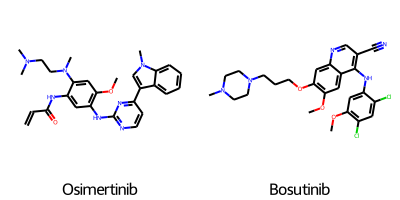

In [ ]:
Osimertinib = query
Bosutinib = Chem.MolFromSmiles("CN1CCN(CC1)CCCOC2=C(C=C3C(=C2)N=CC(=C3NC4=CC(=C(C=C4Cl)Cl)OC)C#N)OC")
Bosutinib.SetProp('_Name',"Bosutinib")

compounds = [Osimertinib, Bosutinib]

Draw.MolsToGridImage(
    [compounds[i] for i in range(len(compounds))],
    legends=[compounds[i].GetProp('_Name') for i in range(len(compounds))],
    molsPerRow=2,
)

## 3.1. Morgan Fingerprint

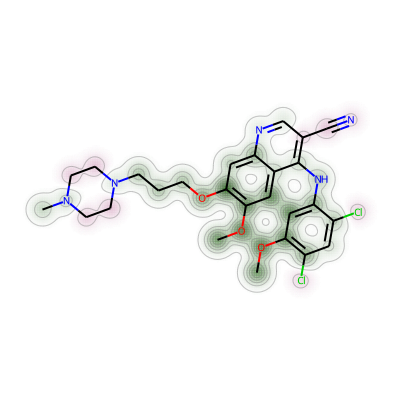

In [ ]:
def show_png(data):
  bio = io.BytesIO(data)
  img = Image.open(bio)
  return img

d = Draw.MolDraw2DCairo(400, 400)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(Osimertinib, Bosutinib, 
                                                                     lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                                                     draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

## 3.2. Morgan count-based Fingerprint

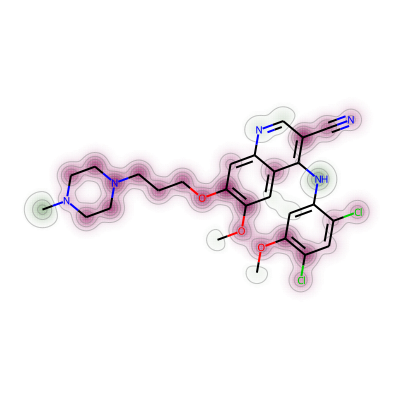

In [ ]:
def show_png(data):
  bio = io.BytesIO(data)
  img = Image.open(bio)
  return img

d = Draw.MolDraw2DCairo(400, 400)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(Osimertinib, Bosutinib, 
                                                                     lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='count'), 
                                                                     draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())


## 3.3. Contributions made by the atoms in Osimertinib to its calculatied logp value

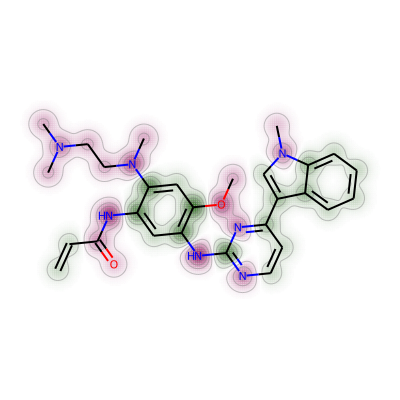

In [ ]:
from rdkit.Chem import rdMolDescriptors
Osi_contribs = rdMolDescriptors._CalcCrippenContribs(Osimertinib)
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(Osimertinib,[x[0] for x in Osi_contribs],draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

## 3.4. Visualizations of various partial charge schemes

### 3.4.1. Gasteiger-Marsilli charges

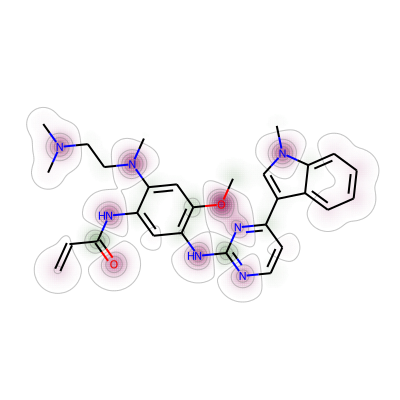

In [ ]:
from rdkit.Chem import rdPartialCharges
rdPartialCharges.ComputeGasteigerCharges(Osimertinib)
chgs = [x.GetDoubleProp("_GasteigerCharge") for x in Osimertinib.GetAtoms()]
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(Osimertinib,chgs,draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

### 3.4.2. Hueckel theory (eHT) using Mulliken analysis

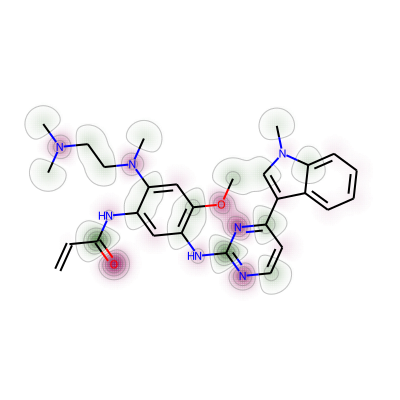

In [ ]:
from rdkit.Chem import rdEHTTools
from rdkit.Chem import rdDistGeom
mh = Chem.AddHs(Osimertinib)
rdDistGeom.EmbedMolecule(mh)
_,res = rdEHTTools.RunMol(mh)
static_chgs = res.GetAtomicCharges()[:Osimertinib.GetNumAtoms()]
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(Osimertinib,list(static_chgs),draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

### 3.4.3. Visualize the variability of the eHT charges with conformation for Osimertinib.

Found 8 conformers


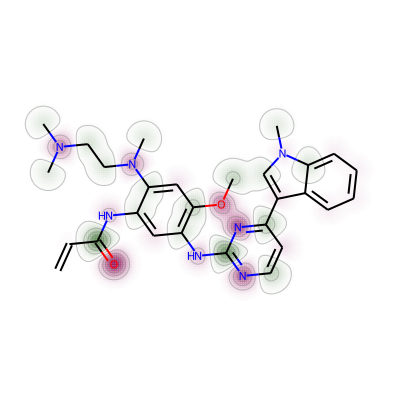

In [ ]:
mh = Chem.AddHs(Osimertinib)
ps = rdDistGeom.ETKDGv2()
ps.pruneRmsThresh = 0.5
ps.randomSeed = 0xf00d
rdDistGeom.EmbedMultipleConfs(mh,10,ps)
print(f'Found {mh.GetNumConformers()} conformers')
chgs = []
for conf in mh.GetConformers():
    _,res = rdEHTTools.RunMol(mh,confId=conf.GetId())
    chgs.append(res.GetAtomicCharges()[:Osimertinib.GetNumAtoms()])
chgs = np.array(chgs)
mean_chgs = np.mean(chgs,axis=0)
std_chgs = np.std(chgs,axis=0)
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(Osimertinib,list(mean_chgs),draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

[0.00282153 0.00518532 0.0097338  0.00595575 0.00678807 0.00586834
 0.00555837 0.00765811 0.00447981 0.00689882 0.00288386 0.02008518
 0.02292674 0.01651292 0.00726957 0.01193159 0.0596909  0.00695315
 0.00947083 0.00941445 0.01148384 0.01181472 0.01161436 0.02366169
 0.00634158 0.01711401 0.00398999 0.00934981 0.02146671 0.00452222
 0.0082888  0.00984815 0.0212393  0.00564414 0.00695668 0.00729511
 0.00496353]
0.05969089675386339 0.0028215330210824693


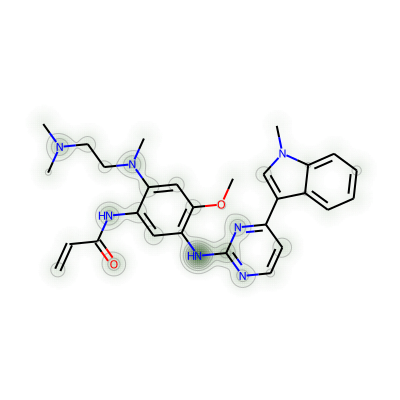

In [ ]:
print(std_chgs)
print(max(std_chgs),min(std_chgs))
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(Osimertinib,list(std_chgs),draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

In [ ]:
class Similarity_Map:
    def __init__(self, query, base):
        self.query = query
        self.base = base
    
    
    def show_png(self, data):
        bio = io.BytesIO(data)
        img = Image.open(bio)
        return img
    
    def similarity_map_bitvect(self):
        d = Draw.MolDraw2DCairo(400, 400)
        _, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(self.query, self.base, 
                                                                     lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                                                     draw2d=d)
        d.FinishDrawing()
        a = self.show_png(d.GetDrawingText())
        a.save("4.png", transparent = True)
        display(self.show_png(d.GetDrawingText()))
        
    def similarity_map_countvect(self):
        d = Draw.MolDraw2DCairo(400, 400)
        _, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(self.query, self.base, 
                                                                     lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='count'), 
                                                                     draw2d=d)
        d.FinishDrawing()
        
        b = self.show_png(d.GetDrawingText())
        b.save("4.1.png", transparent = True)
        display(self.show_png(d.GetDrawingText()))
        
    def plot(self):
        plt.figure(figsize = (16,6))
        plt.subplot(121)
        self.similarity_map_bitvect()
        plt.subplot(122)
        self.similarity_map_countvect()
    

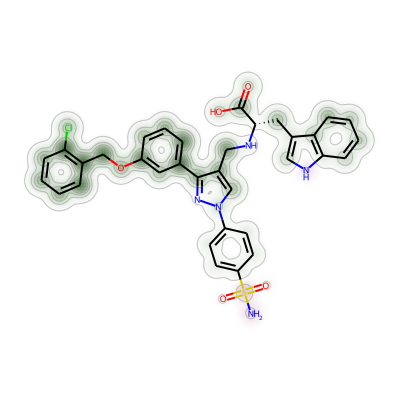

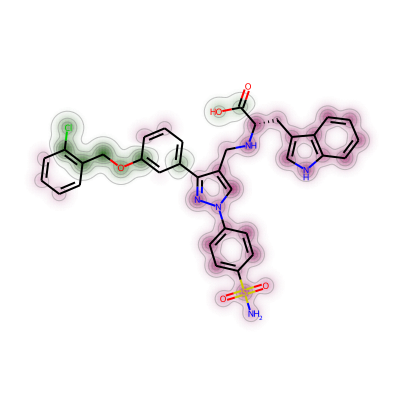

In [ ]:
f = Similarity_Map(atorvastatin, rosuvastatin)
f.similarity_map_bitvect()
f.similarity_map_countvect()

# **4. Enrichment factor**

In [ ]:
class Enrichment_Factor:
    
    def __init__(self,data, similarity_measure, pBio_cutoff, bioactivity, ranked_dataset_percentage_cutoff):
        self.data = data
        self.similarity_measure = similarity_measure
        self.pBio_cutoff = pBio_cutoff
        self.bioactivity = bioactivity
        self.ranked_dataset_percentage_cutoff = ranked_dataset_percentage_cutoff
    
    # 1. Enrichment_data
    def get_enrichment_data(self, similarity_measure):
        """
        Calculates x and y values for enrichment plot:
            x - % ranked dataset
            y - % true actives identified

        Parameters
        ----------
        molecules : pandas.DataFrame
            Molecules with similarity values to a query molecule.
        similarity_measure : str
            Column name which will be used to sort the DataFrame．
        pic50_cutoff : float
            pIC50 cutoff value used to discriminate active and inactive molecules.

        Returns
        -------
        pandas.DataFrame
            Enrichment data: Percentage of ranked dataset by similarity vs. percentage of identified true actives.
        """

        # Get number of molecules in data set
        molecules_all = len(self.data)

        # Get number of active molecules in data set
        actives_all = sum(self.data[self.bioactivity] >= self.pBio_cutoff)

        # Initialize a list that will hold the counter for actives and molecules while iterating through our dataset
        actives_counter_list = []

        # Initialize counter for actives
        actives_counter = 0

        # Note: Data must be ranked for enrichment plots:
        # Sort molecules by selected similarity measure
        self.data.sort_values([similarity_measure], ascending=False, inplace=True)

        # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
        for value in self.data[self.bioactivity]:
            if value >= self.pBio_cutoff:
                actives_counter += 1
            actives_counter_list.append(actives_counter)

        # Transform number of molecules into % ranked dataset
        molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

        # Transform number of actives into % true actives identified
        actives_percentage_list = [i / actives_all for i in actives_counter_list]

        # Generate DataFrame with x and y values as well as label
        self.enrichment = pd.DataFrame(
            {
                "% ranked dataset": molecules_percentage_list,
                "% true actives identified": actives_percentage_list,
            }
        )

        return self.enrichment
    # 2. Get EF data
    def EF(self):
        self.enrichment_data = {
            similarity_measure: self.get_enrichment_data(similarity_measure)
            for similarity_measure in self.similarity_measure}
        print("TANIMOTO ECFP")
        display(self.enrichment_data["tanimoto_ecfp"].head())
        print("DICE ECFP")
        display(self.enrichment_data["dice_ecfp"].head())
        print("TVERSKY ECFP")
        display(self.enrichment_data["Tversky_ecfp"].head())
   
    # 3. Calculate enrichment_factor for dataset
    def calculate_enrichment_factor(self, enrichment):
        """
        Get the experimental enrichment factor for a given percentage of the ranked dataset.

        Parameters
        ----------
        enrichment : pd.DataFrame
            Enrichment data: Percentage of ranked dataset by similarity vs. percentage of
            identified true actives.
        ranked_dataset_percentage_cutoff : float or int
            Percentage of ranked dataset to be included in enrichment factor calculation.

        Returns
        -------
        float
            Experimental enrichment factor.
        """

        # Keep only molecules that meet the cutoff
        enrichment = enrichment[
            enrichment["% ranked dataset"] <= self.ranked_dataset_percentage_cutoff / 100
        ]
        # Get highest percentage of actives and the corresponding percentage of actives
        highest_enrichment = enrichment.iloc[-1]
        enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
        return enrichment_factor
    
    # 4. Calculate random enrichment_factor for dataset
    def calculate_enrichment_factor_random(self):
        """
        Get the random enrichment factor for a given percentage of the ranked dataset.

        Parameters
        ----------
        ranked_dataset_percentage_cutoff : float or int
            Percentage of ranked dataset to be included in enrichment factor calculation.

        Returns
        -------
        float
            Random enrichment factor.
        """

        enrichment_factor_random = round(float(self.ranked_dataset_percentage_cutoff), 1)
        return enrichment_factor_random
    
    # 5. Calculate optimal enrichment_factor for dataset
    def calculate_enrichment_factor_optimal(self):
        """
        Get the optimal random enrichment factor for a given percentage of the ranked dataset.

        Parameters
        ----------
        molecules : pandas.DataFrame
            the DataFrame with all the molecules and pIC50.
        ranked_dataset_percentage_cutoff : float or int
            Percentage of ranked dataset to be included in enrichment factor calculation.
        activity_cutoff: float
            pIC50 cutoff value used to discriminate active and inactive molecules

        Returns
        -------
        float
            Optimal enrichment factor.
        """

        ratio = sum(self.data[self.bioactivity] >= pBio_cutoff) / len(self.data) * 100
        if self.ranked_dataset_percentage_cutoff <= ratio:
            enrichment_factor_optimal = round(100 / ratio * self.ranked_dataset_percentage_cutoff, 1)
        else:
            enrichment_factor_optimal = 100.0
        return enrichment_factor_optimal
    
    # 6. Calculate all enrichment_factor for dataset
    def EF_calculate(self):
        for similarity_measure, enrichment in self.enrichment_data.items():
            enrichment_factor = self.calculate_enrichment_factor(enrichment)
            print(
                f"Experimental EF for {self.ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
            )
        enrichment_factor_random = self.calculate_enrichment_factor_random()
        print(
            f"Random EF for {self.ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%"
        )
        enrichment_factor_optimal = self.calculate_enrichment_factor_optimal()
        print(
            f"Optimal EF for {self.ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%"
        )

    # 7. Plot the enrichment data next to the optimal and random enrichment curve!
    def plot_EF(self):
        
        fig, ax = plt.subplots(figsize=(6, 6))

        fontsize = 20

        # Plot enrichment data
        for similarity_measure, enrichment in self.enrichment_data.items():
            ax = enrichment.plot(
                ax=ax,
                x="% ranked dataset",
                y="% true actives identified",
                label=similarity_measure,
                alpha=0.5,
                linewidth=4,
            )
        ax.set_ylabel("% True actives identified", size=fontsize)
        ax.set_xlabel("% Ranked dataset", size=fontsize)

        # Plot optimal curve: Ratio of actives in dataset
        ratio_actives = sum(self.data[self.bioactivity] >= self.pBio_cutoff) / len(self.data)
        ax.plot(
            [0, ratio_actives, 1],
            [0, 1, 1],
            label="Optimal curve",
            color="black",
            linestyle="--",
        )

        # Plot random curve
        ax.plot([0, 1], [0, 1], label="Random curve", color="red", linestyle="--")

        plt.tick_params(labelsize=16)
        plt.legend(
            labels=["MACCS", "Morgan", "RDKF", "Optimal", "Random"],
            loc=(0.5, 0.08),
            fontsize=fontsize,
            labelspacing=0.3,
        )

        # Save plot -- use bbox_inches to include text boxes
        plt.savefig(
            "enrichment_plot.png",
            dpi=300,
            bbox_inches="tight",
            transparent=True,
        )

        plt.show()

In [ ]:
df.head(2)

,pIC50,tanimoto_ecfp,dice_ecfp,Tversky_ecfp,active
0,11.522879,0.139785,0.245283,0.245283,1.0
1,11.221849,0.156250,0.270270,0.270270,1.0


TANIMOTO ECFP


,% ranked dataset,% true actives identified
0,0.000216,0.000000
1,0.000431,0.000000
2,0.000647,0.001104
3,0.000863,0.002208
4,0.001079,0.003311


DICE ECFP


,% ranked dataset,% true actives identified
0,0.000216,0.000000
1,0.000431,0.000000
2,0.000647,0.001104
3,0.000863,0.002208
4,0.001079,0.003311


TVERSKY ECFP


,% ranked dataset,% true actives identified
0,0.000216,0.000000
1,0.000431,0.000000
2,0.000647,0.001104
3,0.000863,0.002208
4,0.001079,0.003311


Experimental EF for 1% of ranked dataset (tanimoto_ecfp): 2.3%
Experimental EF for 1% of ranked dataset (dice_ecfp): 2.3%
Experimental EF for 1% of ranked dataset (Tversky_ecfp): 2.3%
Random EF for 1% of ranked dataset: 1.0%
Optimal EF for 1% of ranked dataset: 5.1%


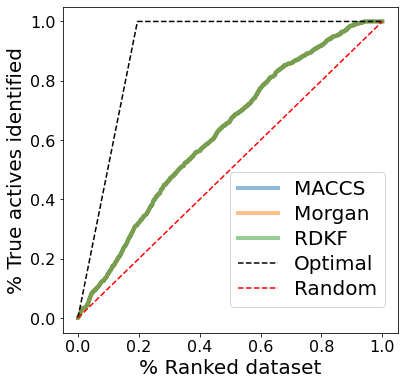

In [ ]:
pBio_cutoff = 8
similarity_measures = ["tanimoto_ecfp", "dice_ecfp", "Tversky_ecfp"]
ef = Enrichment_Factor(data = df, similarity_measure=similarity_measures, pBio_cutoff=pBio_cutoff, 
                       bioactivity = 'pIC50', ranked_dataset_percentage_cutoff = 1
                      )
ef.EF()
ef.EF_calculate()
ef.plot_EF()

In [ ]:
df.head(2)

,pIC50,tanimoto_ecfp,dice_ecfp,Tversky_ecfp,active
4142,4.823909,1.00,1.00000,1.00000,0.0
4397,4.346787,0.88,0.93617,0.93617,0.0


In [ ]:
df = df[["Tversky_ecfp", "active"]]
df

,Tversky_ecfp,active
4142,1.000000,0.0
4397,0.936170,0.0
570,0.923077,1.0
238,0.923077,1.0
690,0.910345,1.0
...,...,...
2727,0.088889,0.0
3161,0.085106,0.0
4624,0.066667,0.0
3957,0.065217,0.0


# 5. ROC analysis

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score,  roc_curve, auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
def plot_roc(active, scores):
        """ Calculates and plots and ROC and AUC.
        Parameters:
        actives_list - binary array of active/decoy status.
        score_list - array of experimental scores.
        tool- a string name of the tool used.
        receptor - a string name of the protein used.
        """
        # Plot figure
        plt.figure()
        fpr, tpr, thresholds = roc_curve(active, scores)
        gmeans = np.sqrt(tpr * (1-fpr))
        roc_auc = round(auc(fpr, tpr),3)
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix],  gmeans[ix]))
        #cutoff = -self.scl.inverse_transform(self.thresholds[ix].reshape(-1, 1))
        print('Cutoff=%.3f kcal/mol' % gmeans[ix])
        lw = 2
        
        plt.plot(fpr, tpr, 
                 lw=lw, label=f'(AUC = %0.3f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize = 16)
        plt.ylabel('True Positive Rate', fontsize = 16)
        plt.title('Receiver operating characteristic', fontsize = 20)
        plt.legend(loc="lower right")
        #plt.savefig("figures/" + tool + "_" + receptor + "_ROC.svg", format="svg")

Best Threshold=0.294118, G-mean=0.605
Cutoff=0.605 kcal/mol


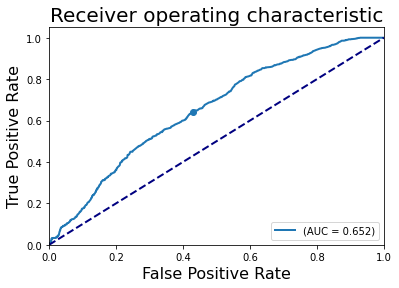

In [ ]:
plot_roc(df.active, df.Tversky_ecfp)